# Bow-Tie II

In this notebook, we will see another way a NOC can emerge which is possible in dense and weighted networks. In those networks, a NOC can appear because its connections are different from the rest, meaning that its weight profiles follow a different pattern than the weight profiles of nodes belonging clearly to a cluster. 

Let's look at what we mean by a "different" weight profile. First, we start loading some libraries and creating a network.

<AxesSubplot: >

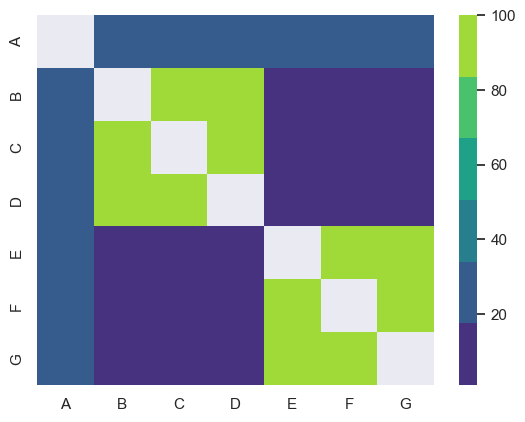

In [1]:
T = True
F = False
# Python libs ----
import numpy as np
import seaborn as sns
# ELK libs ----
from networks.toy import TOY
from modules.main import ELK
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import *

linkage = "single"
lookup = F
cut = F
mode = "ZERO"
topology = "MIX"
index = "H2"
score = "_SL"

properties = {
  "lookup" : lookup,
  "cut" : cut,
  "topology" : topology,
  "index" : index
}

N = 7                               # number of nodes
ww = 1
wm = 25                             
ws = 100
toy = np.array(
  [
    [0, wm, wm, wm, wm, wm, wm],
    [wm, 0, ws, ws, ww, ww, ww],
    [wm, ws, 0, ws, ww, ww, ww],
    [wm ,ws, ws, 0, ww, ww, ww],
    [wm, ww, ww, ww, 0, ws, ws],
    [wm, ww, ww, ww, ws, 0, ws],
    [wm, ww, ww, ww, ws, ws, 0]
  ]
, dtype=float)

np.fill_diagonal(toy, np.nan)
labels = np.array(["A", "B", "C", "D", "E", "F", "G"])
sns.heatmap(
  toy, xticklabels=labels, yticklabels=labels,
  cmap=sns.color_palette("viridis")
)

As seen above, the network is very dense, but clearly, there are two communities, the ones formed by nodes B, C, and D, and the one created by nodes E, F, and G. We say that they form a community because the weight between them is more extensive than with the rest of the nodes.

## Explanation before running the code

We can see that the incoming (target) or outgoing (source) weights from the nodes belonging to the same cluster, e.g., nodes B and C, are very similar. If you look at them, they are strong between themselves and low outside in both directions. This happens in the nodes belonging to a cluster; however, we can observe that the connectivity profile of node A is very different. By comparing its target and source connections with the rest, we can see that the node is different since it is engaged with the two clusters, not only one. The dissimilarity between node A and the other nodes will make them merge at the latest steps in the hierarchical agglomeration process. Nevertheless, they will collapse the system when they join, creating a massive community.

In a dense network and depending on the weighted connectivity profile, the node communities will be created fast, leaving the more different nodes outside. At the same time, the links of the various nodes will form link communities since their distance depends on other nodes, most likely belonging clearly to node communities. However, if the different node has properties from other clusters, its links, which are a link community, will only merge with the rest of the links once the groups of the dissimilar node have affinity merge. Only when those clusters merge, reducing the homogeneity of the network, increasing the average link density substantially, and also the loop entropy since link communities have more uniform sizes. However, since that transition changes the fitness function, e.g., $H_{L}$, the partition before the merging will be picked. So, a sign of a node belonging to multiple clusters is when its links are still tree-link communities at the best partition.

Now, let's see what the algorithm does.


In [2]:
np.fill_diagonal(toy, 0)
NET = TOY(toy, **properties)
labels_dict = dict()
for i in np.arange(N):
  labels_dict[i] = labels[i]
NET.set_labels(
  labels
)
H = ELK(NET.A, N, linkage, mode, **properties)
## Compute features ----
H.compute_H_features_cpp()
## Compute link entropy ----
H.link_entropy_cpp("short", cut=cut)
## Compute lq arbre de merde ----
H.la_abre_a_merde_cpp()
## Compute node entropy ----
H.node_entropy_cpp("short", cut=cut)
# Set labels to network ----
L = colregion(NET)
L.get_regions()
H.set_colregion(L)

Compute link hierarchical agglomeration ----
	> Compute features

	link entropy :  Sh : 0.2849, and Sv : 0.7151


	link entropy H: Sh : 0.2467, and Sv : 0.7533

	> Compute the node hierarchy ----
75%
Starting Z2dict

	Node entropy :  Sh : 0.2012, and Sv : 0.7988


	Node entropy H: Sh : 0.1007, and Sv : 0.8993

Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 83
Commencer: la abre a merde
Voila, bon ami
Starting Z2dict
Level information
Vertex entropy
Vertex entropy H
Level entropy
Level entropy H
Number of vertices in the tree: 13


{}
{0: ['A', 'B', 'C', 'D'], 1: ['E', 'F', 'G']}
Visualize nodal dendrogram!!!
	> Plot network!!!
Draw networkx link communities!!!


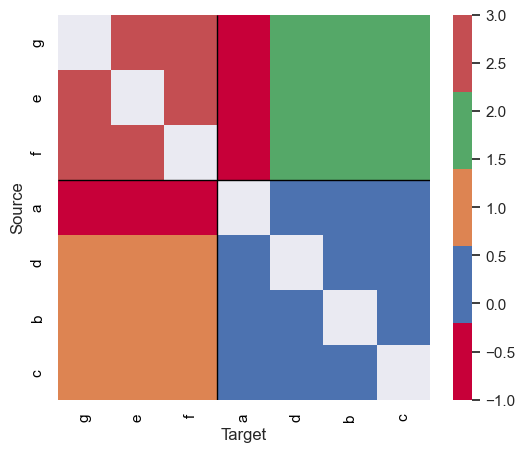

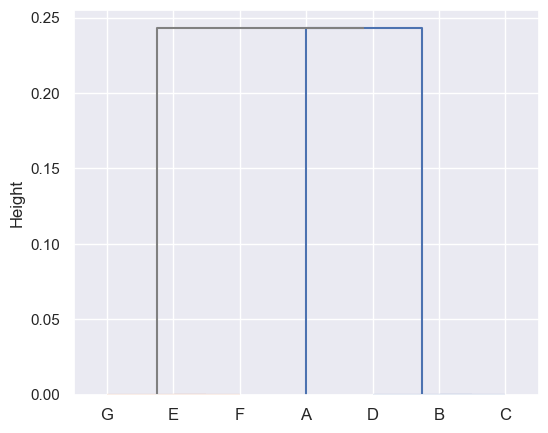

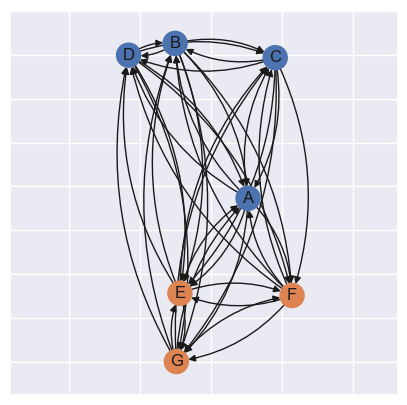

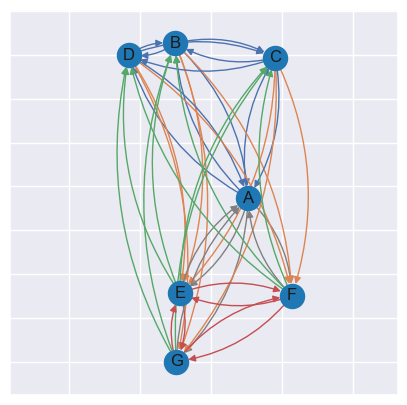

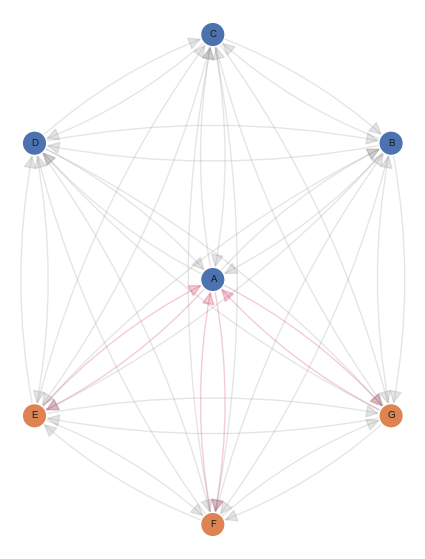

In [3]:
# Plot H ----
plot_h = Plot_H(H)
k, r = get_best_kr_equivalence(score, H)
rlabels = get_labels_from_Z(H.Z, r)
rlabels = skim_partition(rlabels)
noc, subcover, sizes, rlabels2 = H.discovery(rlabels, k, direction="both", index=index)
# Which are the NOCs?
print(subcover)
cover = omega_index_format(
  rlabels2, subcover, H.colregion.labels[:H.nodes]
)
# What is the cover?
print(cover)
plot_h.lcmap_dendro(
  r, k, cmap_name="deep", width=6, height=5
)
plot_h.nodal_dendrogram(
  r, cmap_name="deep", width=6, height=5
)
plot_h.plot_network_simple(
  rlabels2, cmap_name="deep", width=5, height=5,
  labels=labels_dict
)
plot_h.plot_link_communities(
  k, cmap_name="deep", width=5, height=5,
  labels=labels_dict
)
plot_h.plot_network_combined(
  k, np.log(1 + H.A), rlabels2, subcover, sizes,
  ang=0, font_size=7, cmap_name="deep", width=7, height=7
)

We can observe in the first plot that most of the links adjacent to A were tree-link communities because of their carmine color. In the second plot, the node dendrogram, we see that the node communities were formed while A was left apart. In the following two figures, we can see that A is a node living in between the two node communities. In a sense, this type of NOC exists in weighted and dense graphs, and it has a different origin from the class explained in **BowTie_example_one.ipynb**. 

## Conclusion

Dense-weighted networks can present another type of NOCs from the topological ones. In real networks, both types could exist, which is essential to notice. We have designed an algorithm for both cases to try to find them. However, it could be better for that new theoretical and experimental ideas to understand deeply what is happening, e.g., if we change the weights of node A to be different, the type of NOC from this example would not appear.